In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# ---------------------- Imports ----------------------

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary 
import onnx 
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import os
import datetime
import matplotlib.pyplot as plt

# ---------------------- Dataset Class ----------------------

In [3]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# ---------------------- Paths & Setup ----------------------

In [4]:
# List of folders
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB"
]

mask_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB"
]

# Collect all images and masks
image_files = []
mask_files = []

for img_dir, msk_dir in zip(image_dirs, mask_dirs):
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])
    msks = sorted([os.path.join(msk_dir, f) for f in os.listdir(msk_dir) if f.endswith(".jpg") or f.endswith(".png")])

    assert len(imgs) == len(msks), f"Mismatch in number of images and masks in {img_dir}"

    image_files.extend(imgs)
    mask_files.extend(msks)

# Split into training and test sets
# First split: 80% train, 20% temp (to be split into val/test)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Second split: 10% val, 10% test (i.e., split temp in half)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

#train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# ---------------- Datasets and DataLoaders ----------------

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SaliencyDataset(train_imgs, train_masks, transform=transform)
val_dataset = SaliencyDataset(val_imgs, val_masks, transform=transform)
test_dataset = SaliencyDataset(test_imgs, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ---------------------- Verify dataset ----------------------

Total images: 31566
Total masks: 31566
Training images: 25252, Training masks: 25252
Validation images: 3157, Validation masks: 3157
Testing images: 3157, Testing masks: 3157


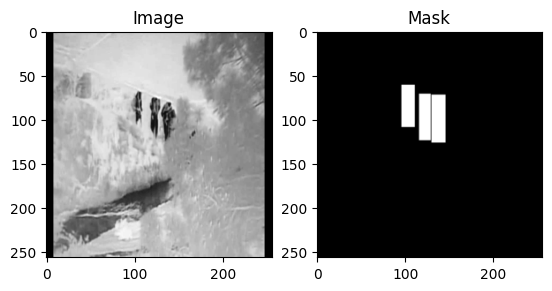

In [6]:
print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")
print(f"Training images: {len(train_imgs)}, Training masks: {len(train_masks)}")
print(f"Validation images: {len(val_imgs)}, Validation masks: {len(val_masks)}")
print(f"Testing images: {len(test_imgs)}, Testing masks: {len(test_masks)}")
# Visualize some train images and masks
img, msk = train_dataset[100]
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(msk.squeeze(), cmap='gray')
plt.title('Mask')
plt.show()

# ---------------------- Defined Model ----------------------

In [7]:
class Saliency_IR_v1(nn.Module):
    def __init__(self):
        super(Saliency_IR_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training Setup

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(HybridLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.dice(inputs, targets)


In [9]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25, log_prefix="exp", device="cuda"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./training_logs/{log_prefix}_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)

    train_losses, val_losses, lrs = [], [], []
    best_val_loss = float('inf')
    best_model_path = os.path.join(log_dir, "best_model.pth")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        if scheduler:
            scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Saved best model at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.grid(True)
    plt.savefig(os.path.join(log_dir, "loss_plot.png"))
    plt.show()

    # Optionally save CSV
    with open(os.path.join(log_dir, "loss_log.csv"), "w") as f:
        f.write("epoch,train_loss,val_loss,lr\n")
        for i in range(num_epochs):
            f.write(f"{i+1},{train_losses[i]:.4f},{val_losses[i]:.4f},{lrs[i]:.6f}\n")

    return best_model_path

In [10]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    """
    Compute the minimum non-zero area fraction across all ground-truth masks.
    binarization uses bin_thresh, but this only drives area fraction computation.
    """
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

def evaluate_model(
    model,
    dataloader,
    device,
    bin_thresh=0.5,
    area_frac=None,
    compute_area_frac=False,
    beta2=0.3,
    save_model_path=None,
    visualize=False
):
    """
    Evaluate a saliency model.

    Args:
      model:          the torch model in eval mode
      dataloader:     DataLoader for GT/test images
      device:         'cuda' or 'cpu'
      bin_thresh:     threshold to binarize saliency maps (default 0.5)
      area_frac:      pixel fraction for object-presence logic
      compute_area_frac: if True, override area_frac by computing from GT masks
      beta2:          beta^2 for weighted F-score
      save_model_path: optional path to save model weights
      visualize:      if True, display one example
    
    Returns:
      dict of metrics + used thresholds
    """
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f} from GT masks")

    # Metrics accumulators
    mae_sum = 0
    prec_sum = 0
    rec_sum = 0
    iou_list = []
    y_true, y_pred = [], []
    n = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]; gt = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binary masks
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec = tp / (tp+fp+1e-8)
                rec  = tp / (tp+fn+1e-8)
                prec_sum += prec; rec_sum += rec
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                # Object-presence
                def has_obj(mask):
                    return (mask.sum() / mask.size) > area_frac
                y_true.append(has_obj(gbin))
                y_pred.append(has_obj(pbin))

                n += 1

    # Final aggregations
    mae      = mae_sum / n
    precision= prec_sum / n
    recall   = rec_sum / n
    fbeta    = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou     = np.mean(iou_list)
    tp_obj   = sum(t and p for t,p in zip(y_true,y_pred))
    fn_obj   = sum(t and not p for t,p in zip(y_true,y_pred))
    obj_recl = tp_obj / (tp_obj+fn_obj+1e-6)

    # Print
    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_recl:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    # Optional visualize
    if visualize:
        img, gt_mask = images[0], masks[0][0]
        pred_mask = outputs[0][0]
        fig, axs = plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(img.permute(1,2,0).cpu());     axs[0].set_title("Image")
        axs[1].imshow(gt_mask.cpu(),cmap='gray');   axs[1].set_title("GT Mask")
        axs[2].imshow(pred_mask,cmap='gray');       axs[2].set_title("Pred Mask")
        plt.show()

    # Optional save model
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"[INFO] Model saved to {save_model_path}")

    return {
        "mae":mae, "precision":precision, "recall":recall,
        "f_beta":fbeta, "miou":miou, "obj_recall":obj_recl,
        "bin_thresh":bin_thresh, "area_frac":area_frac
    }


### Training

Epoch [1/25] | LR: 0.001000 | Train Loss: 0.1231 | Val Loss: 0.0937
  Saved best model at epoch 1 (Val Loss: 0.0937)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.0941 | Val Loss: 0.0826
  Saved best model at epoch 2 (Val Loss: 0.0826)
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.0849 | Val Loss: 0.0755
  Saved best model at epoch 3 (Val Loss: 0.0755)
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.0766 | Val Loss: 0.0720
  Saved best model at epoch 4 (Val Loss: 0.0720)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.0713 | Val Loss: 0.0639
  Saved best model at epoch 5 (Val Loss: 0.0639)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.0659 | Val Loss: 0.0587
  Saved best model at epoch 6 (Val Loss: 0.0587)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.0623 | Val Loss: 0.0575
  Saved best model at epoch 7 (Val Loss: 0.0575)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.0588 | Val Loss: 0.0519
  Saved best model at epoch 8 (Val Loss: 0.0519)
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.0561 | Val Loss: 0.0

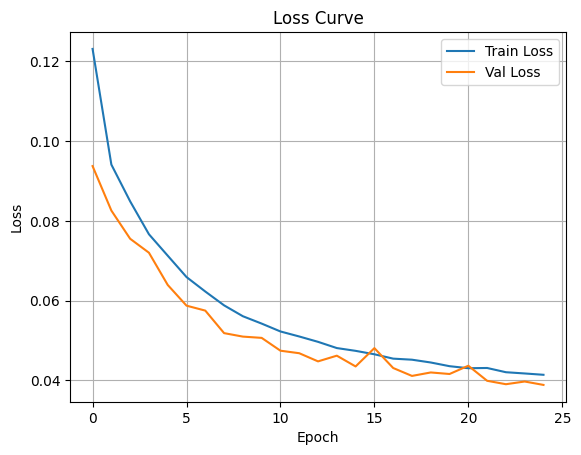

'./training_logs/fixed_bce_20250508_123007/best_model.pth'

In [11]:
# 1. Fixed LR, BCE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, criterion, optimizer, log_prefix="fixed_bce")

[INFO] Computed area_frac=0.000305 from GT masks

=== Evaluation Results ===
MAE            : 0.0216
Precision      : 0.7670
Recall         : 0.6053
Fβ (β²=0.3): 0.7225
Mean IoU       : 0.6160
Obj Presence R : 0.9796
Binarize thres.: 0.50
Area fraction  : 0.000305


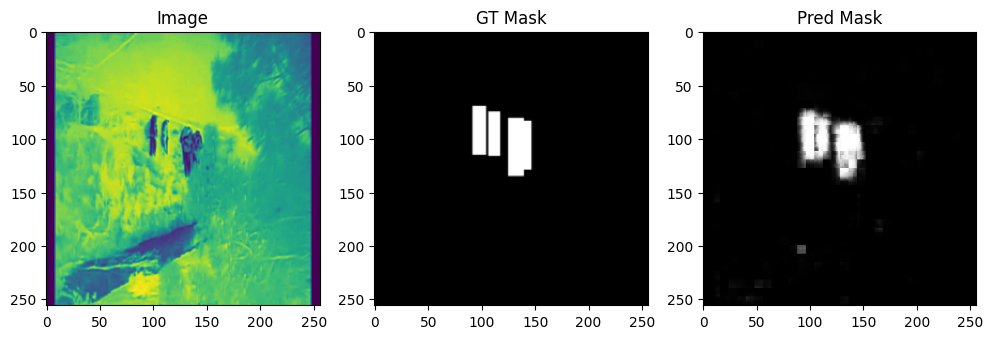


=== Evaluation Results ===
MAE            : 0.0216
Precision      : 0.7134
Recall         : 0.6940
Fβ (β²=0.3): 0.7088
Mean IoU       : 0.6339
Obj Presence R : 0.9874
Binarize thres.: 0.30
Area fraction  : 0.001000


In [12]:
# 1) Default 0.5 bin_thresh, compute area_frac from GT masks:
metrics = evaluate_model(
    model, test_loader, device,
    compute_area_frac=True,
    visualize=True
)

# 2) Fixed area_frac=0.001, custom bin_thresh=0.6:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=False
)


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25] | LR: 0.001000 | Train Loss: 0.1317 | Val Loss: 0.0992
  Saved best model at epoch 1 (Val Loss: 0.0992)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.0967 | Val Loss: 0.0838
  Saved best model at epoch 2 (Val Loss: 0.0838)
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.0883 | Val Loss: 0.0788
  Saved best model at epoch 3 (Val Loss: 0.0788)
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.0825 | Val Loss: 0.0738
  Saved best model at epoch 4 (Val Loss: 0.0738)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.0771 | Val Loss: 0.0713
  Saved best model at epoch 5 (Val Loss: 0.0713)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.0722 | Val Loss: 0.0637
  Saved best model at epoch 6 (Val Loss: 0.0637)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.0682 | Val Loss: 0.0625
  Saved best model at epoch 7 (Val Loss: 0.0625)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.0653 | Val Loss: 0.0592
  Saved best model at epoch 8 (Val Loss: 0.0592)
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.0635 | Val Loss: 0.0

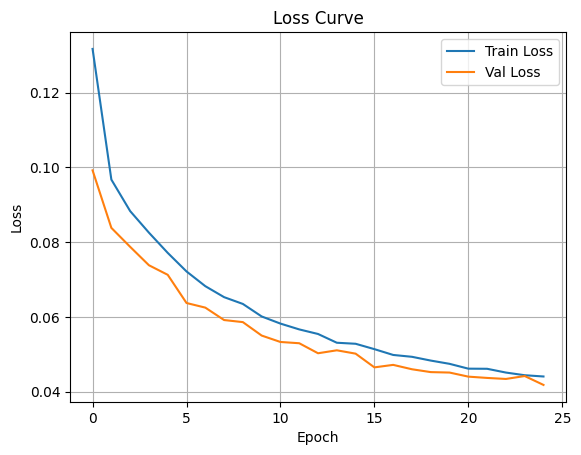

'./training_logs/decay_bce_20250508_154913/best_model.pth'

In [13]:
# 2. Decaying LR, BCE
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
criterion = nn.BCELoss()
train_model(model, criterion, optimizer, scheduler, log_prefix="decay_bce")

[INFO] Computed area_frac=0.000305 from GT masks

=== Evaluation Results ===
MAE            : 0.0237
Precision      : 0.7580
Recall         : 0.5954
Fβ (β²=0.3): 0.7131
Mean IoU       : 0.5997
Obj Presence R : 0.9704
Binarize thres.: 0.50
Area fraction  : 0.000305


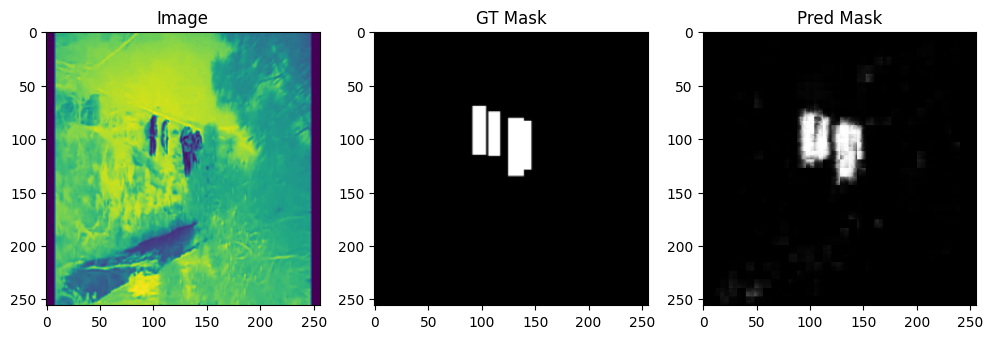


=== Evaluation Results ===
MAE            : 0.0237
Precision      : 0.6942
Recall         : 0.6826
Fβ (β²=0.3): 0.6915
Mean IoU       : 0.6089
Obj Presence R : 0.9836
Binarize thres.: 0.30
Area fraction  : 0.001000


In [14]:
# 1) Default 0.5 bin_thresh, compute area_frac from GT masks:
metrics = evaluate_model(
    model, test_loader, device,
    compute_area_frac=True,
    visualize=True
)

# 2) Fixed area_frac=0.001, custom bin_thresh=0.6:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=False
)


Epoch [1/25] | LR: 0.001000 | Train Loss: 0.7092 | Val Loss: 0.5461
  Saved best model at epoch 1 (Val Loss: 0.5461)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.5469 | Val Loss: 0.4897
  Saved best model at epoch 2 (Val Loss: 0.4897)
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.5050 | Val Loss: 0.4677
  Saved best model at epoch 3 (Val Loss: 0.4677)
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.4803 | Val Loss: 0.4446
  Saved best model at epoch 4 (Val Loss: 0.4446)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.4713 | Val Loss: 0.4340
  Saved best model at epoch 5 (Val Loss: 0.4340)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.4540 | Val Loss: 0.4228
  Saved best model at epoch 6 (Val Loss: 0.4228)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.4418 | Val Loss: 0.4100
  Saved best model at epoch 7 (Val Loss: 0.4100)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.4300 | Val Loss: 0.3945
  Saved best model at epoch 8 (Val Loss: 0.3945)
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.4159 | Val Loss: 0.3

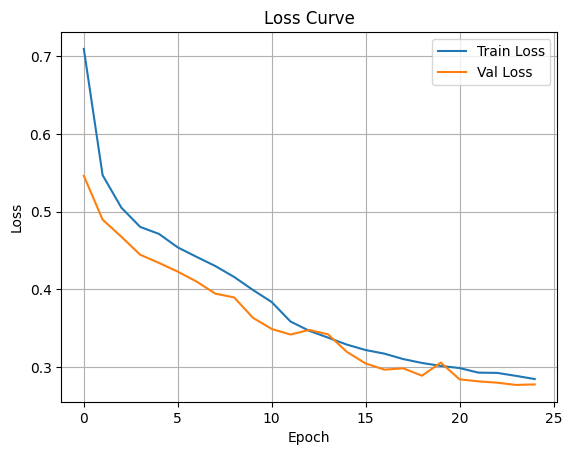

'./training_logs/fixed_dice_20250508_190744/best_model.pth'

In [15]:
# 3. Fixed LR, Dice
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = DiceLoss()
train_model(model, criterion, optimizer, log_prefix="fixed_dice")

[INFO] Computed area_frac=0.000305 from GT masks

=== Evaluation Results ===
MAE            : 0.0145
Precision      : 0.7287
Recall         : 0.6267
Fβ (β²=0.3): 0.7023
Mean IoU       : 0.6139
Obj Presence R : 0.9571
Binarize thres.: 0.50
Area fraction  : 0.000305


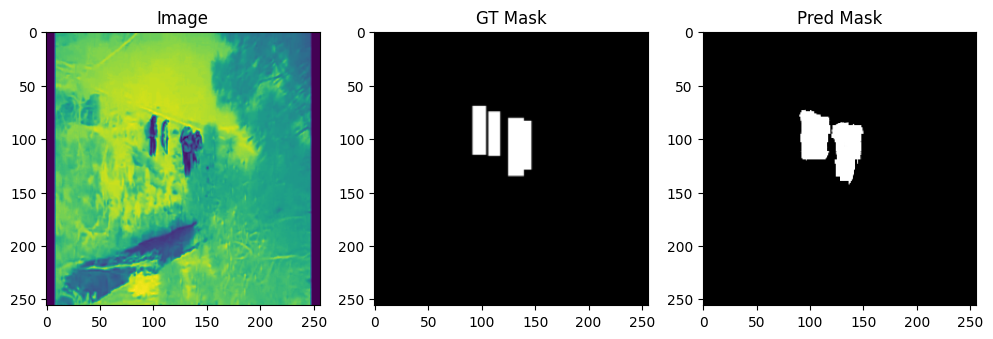


=== Evaluation Results ===
MAE            : 0.0145
Precision      : 0.7379
Recall         : 0.6191
Fβ (β²=0.3): 0.7066
Mean IoU       : 0.6136
Obj Presence R : 0.9413
Binarize thres.: 0.30
Area fraction  : 0.001000


In [16]:
# 1) Default 0.5 bin_thresh, compute area_frac from GT masks:
metrics = evaluate_model(
    model, test_loader, device,
    compute_area_frac=True,
    visualize=True
)

# 2) Fixed area_frac=0.001, custom bin_thresh=0.6:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=False
)


Epoch [1/25] | LR: 0.001000 | Train Loss: 0.6942 | Val Loss: 0.5545
  Saved best model at epoch 1 (Val Loss: 0.5545)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.5333 | Val Loss: 0.5589
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.5041 | Val Loss: 0.5169
  Saved best model at epoch 3 (Val Loss: 0.5169)
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.4829 | Val Loss: 0.4469
  Saved best model at epoch 4 (Val Loss: 0.4469)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.4634 | Val Loss: 0.4362
  Saved best model at epoch 5 (Val Loss: 0.4362)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.4502 | Val Loss: 0.4343
  Saved best model at epoch 6 (Val Loss: 0.4343)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.4408 | Val Loss: 0.4118
  Saved best model at epoch 7 (Val Loss: 0.4118)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.4308 | Val Loss: 0.3967
  Saved best model at epoch 8 (Val Loss: 0.3967)
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.4192 | Val Loss: 0.3892
  Saved best model at epoch 9 (Val Loss: 0.38

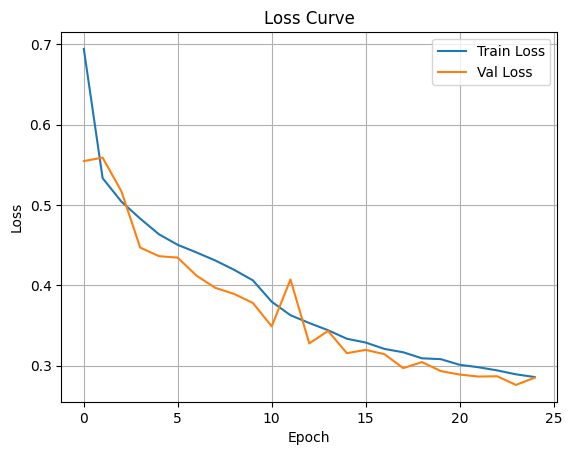

'./training_logs/decay_dice_20250508_230945/best_model.pth'

In [17]:
# 4. Decaying LR, Dice
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
criterion = DiceLoss()
train_model(model, criterion, optimizer, scheduler, log_prefix="decay_dice")

[INFO] Computed area_frac=0.000305 from GT masks

=== Evaluation Results ===
MAE            : 0.0162
Precision      : 0.6582
Recall         : 0.6800
Fβ (β²=0.3): 0.6631
Mean IoU       : 0.5700
Obj Presence R : 0.9765
Binarize thres.: 0.50
Area fraction  : 0.000305


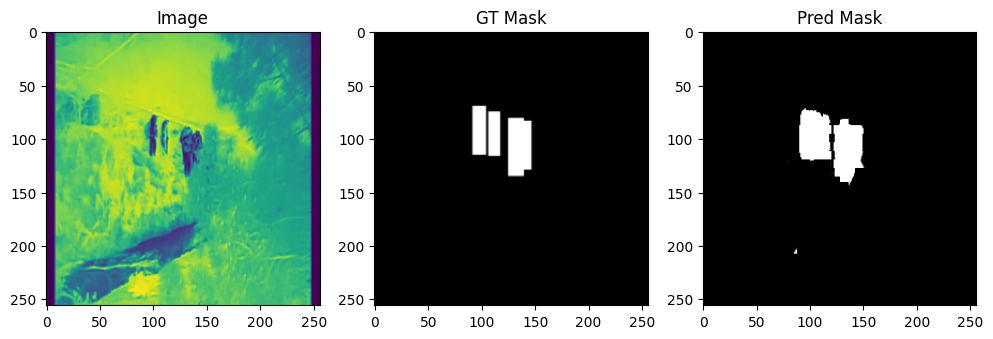


=== Evaluation Results ===
MAE            : 0.0162
Precision      : 0.6671
Recall         : 0.6745
Fβ (β²=0.3): 0.6688
Mean IoU       : 0.5701
Obj Presence R : 0.9648
Binarize thres.: 0.30
Area fraction  : 0.001000


In [18]:
# 1) Default 0.5 bin_thresh, compute area_frac from GT masks:
metrics = evaluate_model(
    model, test_loader, device,
    compute_area_frac=True,
    visualize=True
)

# 2) Fixed area_frac=0.001, custom bin_thresh=0.6:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=False
)


Epoch [1/25] | LR: 0.001000 | Train Loss: 0.3392 | Val Loss: 0.2616
  Saved best model at epoch 1 (Val Loss: 0.2616)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.2506 | Val Loss: 0.2210
  Saved best model at epoch 2 (Val Loss: 0.2210)
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.2214 | Val Loss: 0.2281
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.2031 | Val Loss: 0.1871
  Saved best model at epoch 4 (Val Loss: 0.1871)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.1894 | Val Loss: 0.1706
  Saved best model at epoch 5 (Val Loss: 0.1706)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.1781 | Val Loss: 0.1678
  Saved best model at epoch 6 (Val Loss: 0.1678)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.1707 | Val Loss: 0.1570
  Saved best model at epoch 7 (Val Loss: 0.1570)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.1629 | Val Loss: 0.1610
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.1586 | Val Loss: 0.1528
  Saved best model at epoch 9 (Val Loss: 0.1528)
Epoch [10/25] | LR: 0.001000 | Train Loss: 0.

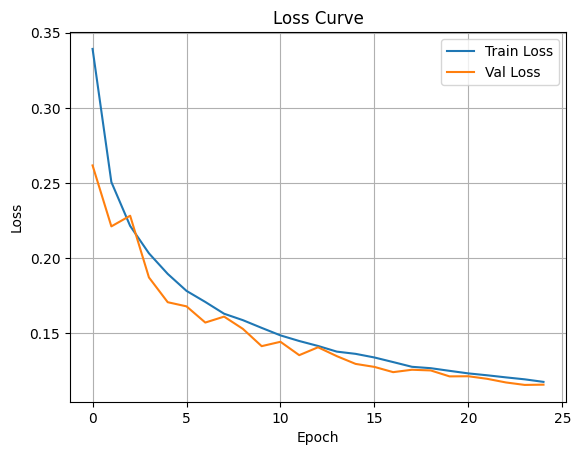

'./training_logs/fixed_hybrid_20250509_020010/best_model.pth'

In [19]:
# 5. Fixed LR, Hybrid Loss (alpha=0.7)
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = HybridLoss(alpha=0.7)
train_model(model, criterion, optimizer, log_prefix="fixed_hybrid")

[INFO] Computed area_frac=0.000305 from GT masks

=== Evaluation Results ===
MAE            : 0.0150
Precision      : 0.7396
Recall         : 0.6888
Fβ (β²=0.3): 0.7273
Mean IoU       : 0.6523
Obj Presence R : 0.9922
Binarize thres.: 0.50
Area fraction  : 0.000305


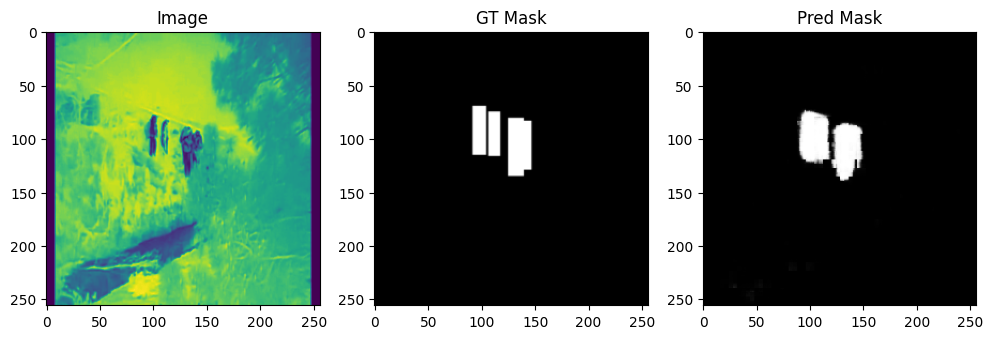


=== Evaluation Results ===
MAE            : 0.0150
Precision      : 0.7266
Recall         : 0.7035
Fβ (β²=0.3): 0.7212
Mean IoU       : 0.6505
Obj Presence R : 0.9891
Binarize thres.: 0.30
Area fraction  : 0.001000


In [20]:
# 1) Default 0.5 bin_thresh, compute area_frac from GT masks:
metrics = evaluate_model(
    model, test_loader, device,
    compute_area_frac=True,
    visualize=True
)

# 2) Fixed area_frac=0.001, custom bin_thresh=0.6:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=False
)


In [ ]:
# 6. Decaying LR, Hybrid Loss (alpha=0.7)
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
criterion = HybridLoss(alpha=0.7)
train_model(model, criterion, optimizer, scheduler, log_prefix="decay_hybrid")

Epoch [1/25] | LR: 0.001000 | Train Loss: 0.3403 | Val Loss: 0.2591
  Saved best model at epoch 1 (Val Loss: 0.2591)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.2509 | Val Loss: 0.2210
  Saved best model at epoch 2 (Val Loss: 0.2210)
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.2224 | Val Loss: 0.1980
  Saved best model at epoch 3 (Val Loss: 0.1980)
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.2002 | Val Loss: 0.1760
  Saved best model at epoch 4 (Val Loss: 0.1760)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.1865 | Val Loss: 0.1703
  Saved best model at epoch 5 (Val Loss: 0.1703)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.1754 | Val Loss: 0.1598
  Saved best model at epoch 6 (Val Loss: 0.1598)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.1653 | Val Loss: 0.1526
  Saved best model at epoch 7 (Val Loss: 0.1526)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.1593 | Val Loss: 0.1466
  Saved best model at epoch 8 (Val Loss: 0.1466)
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.1527 | Val Loss: 0.1

In [ ]:
# 1) Default 0.5 bin_thresh, compute area_frac from GT masks:
metrics = evaluate_model(
    model, test_loader, device,
    compute_area_frac=True,
    visualize=True
)

# 2) Fixed area_frac=0.001, custom bin_thresh=0.6:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=False
)
